<a href="https://colab.research.google.com/github/yubin012/OpenSource_project_Music_Instrument/blob/main/ONLY_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q evaluate transformers==4.28.1
!pip install -U -q datasets
!pip install -q torchaudio==0.12
!add-apt-repository -y ppa:savoury1/ffmpeg4
!apt-get -qq install -y ffmpeg
!pip install -q mlflow
!pip install resampy==0.2.2
!pip install librosa numpy pandas

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d soumendraprasad/musical-instruments-sound-dataset

100% 5.39G/5.40G [03:22<00:00, 26.7MB/s]
100% 5.40G/5.40G [03:22<00:00, 28.6MB/s]


In [ ]:
!ls

drive  kaggle.json  musical-instruments-sound-dataset.zip  sample_data


In [ ]:
! unzip musical-instruments-sound-dataset.zip

In [ ]:
#imports
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display
import resampy

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas()
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import torch
import datasets
import transformers
print(transformers.__version__)

4.28.1


#1. 데이터 전처리

In [ ]:
# before start
# 메타데이터 데이터 시각화

In [ ]:
df=pd.read_csv("Metadata_Train.csv")
df2=pd.read_csv("Metadata_Test.csv")
df

,FileName,Class
0,1-E1-Major 00.wav,Sound_Guitar
1,1-E1-Major 01.wav,Sound_Guitar
2,1-E1-Major 02.wav,Sound_Guitar
3,1-E1-Major 03.wav,Sound_Guitar
4,1-E1-Major 04.wav,Sound_Guitar
...,...,...
2624,strange-piano-73881.wav,Sound_Piano
2625,the-last-piano-112677.wav,Sound_Piano
2626,this-is-war-version-e-95411.wav,Sound_Piano
2627,tired-ghosts-piano-65013.wav,Sound_Piano


In [ ]:
df['Class'].value_counts()

Sound_Guitar    700
Sound_Drum      700
Sound_Violin    700
Sound_Piano     529
Name: Class, dtype: int64

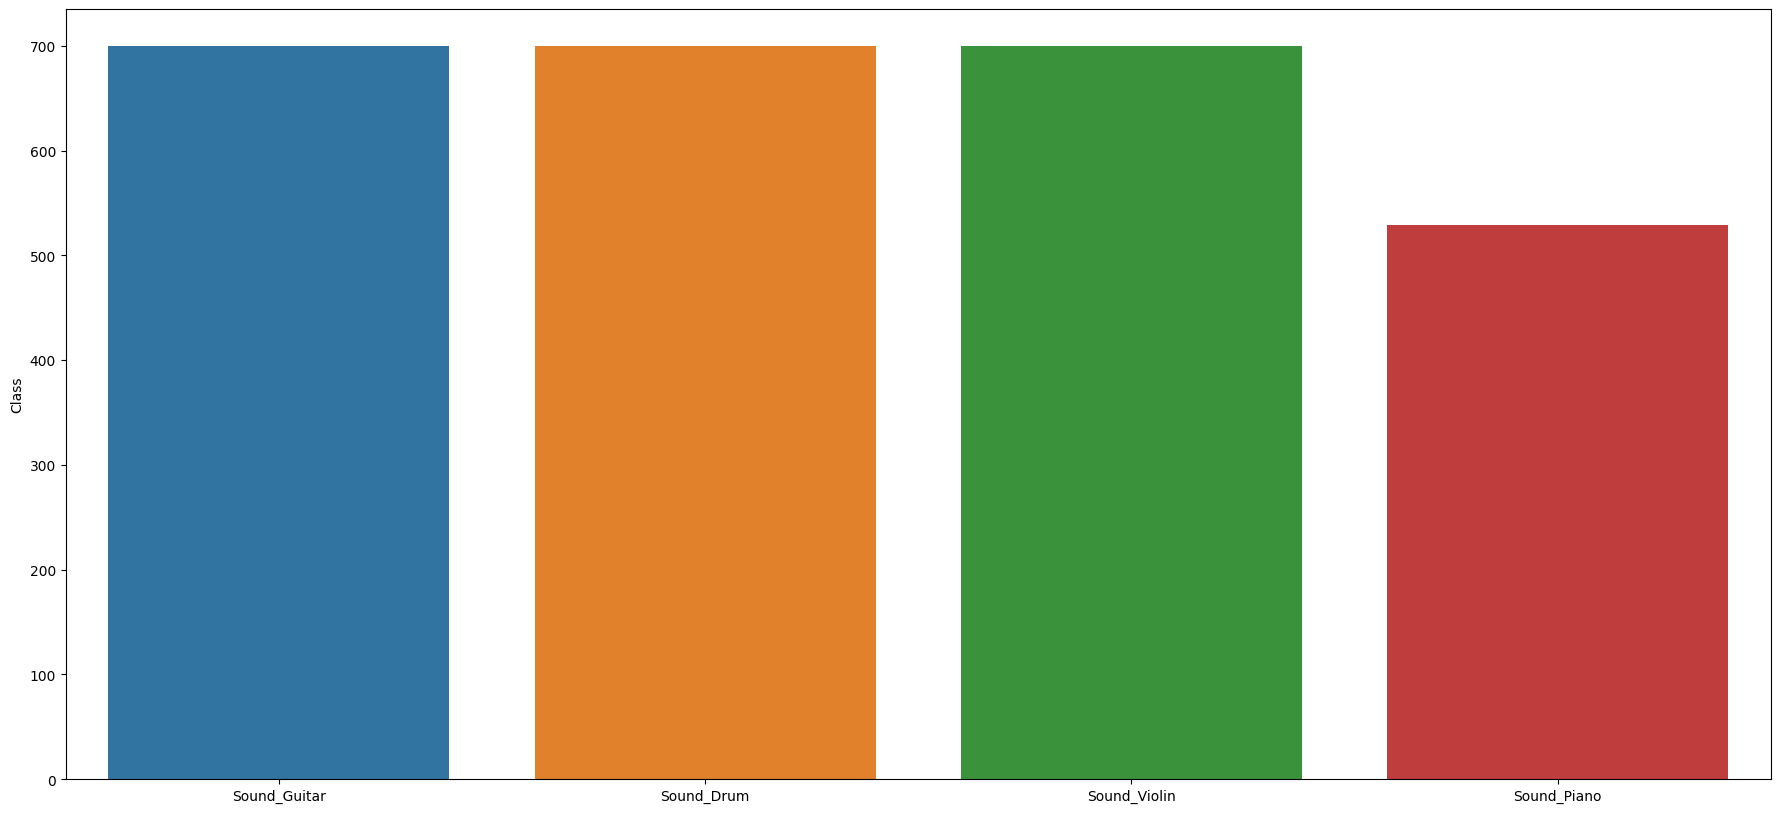

In [ ]:
plt.figure(figsize=(22, 10))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts())
plt.xticks(rotation=0)
plt.show()

In [ ]:
RATE_HZ = 16000  # 리샘플링된 주파수(Hz)
MAX_LENGTH = 240000  # 고려할 최대 오디오 구간 길이(= RATE_HZ * SECONDS)
labels = ['Sound_Guitar', 'Sound_Drum', 'Sound_Piano','Sound_Violin']  # 음악 악기 레이블 목록

# 레이블과 해당 ID 간의 매핑을 위한 딕셔너리 생성
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

# 결과 출력
print(id2label, '\n\n', label2id)

{0: 'Sound_Guitar', 1: 'Sound_Drum', 2: 'Sound_Piano', 3: 'Sound_Violin'} 

 {'Sound_Guitar': 0, 'Sound_Drum': 1, 'Sound_Piano': 2, 'Sound_Violin': 3}


In [ ]:
# 'Class' 열의 각 값에 대한 label 값을 찾아서 'label' 열에 추가
df['label'] = df['Class'].map(label2id)

# 결과 출력
df

,FileName,Class,label
0,1-E1-Major 00.wav,Sound_Guitar,0
1,1-E1-Major 01.wav,Sound_Guitar,0
2,1-E1-Major 02.wav,Sound_Guitar,0
3,1-E1-Major 03.wav,Sound_Guitar,0
4,1-E1-Major 04.wav,Sound_Guitar,0
...,...,...,...
2624,strange-piano-73881.wav,Sound_Piano,2
2625,the-last-piano-112677.wav,Sound_Piano,2
2626,this-is-war-version-e-95411.wav,Sound_Piano,2
2627,tired-ghosts-piano-65013.wav,Sound_Piano,2


# 데이터 로드

In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio

## Hamoronic 시각화

In [ ]:
def visualise_audio(wav: torch.Tensor, sr:int):
    if wav.dim() == 2:
        wav = wav.mean(dim = 0)
    plt.figure(figsize= (20,5))
    plt.plot(wav, alpha =.7, c='blue')
    plt.grid()
    plt.xlabel('Time', size = 20)
    plt.ylabel('Amplitude', size = 20)
    plt.show()

In [ ]:
class MusicDataset(Dataset):
    SR = 44100

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        directory = 'Train_submission/Train_submission'
        filename = directory + '/' + self.df.iloc[idx]['FileName']
        instrument = self.df.iloc[idx]['Class']

        audio_data, sr = torchaudio.load(filename)
        if audio_data.shape[0] > 1:
            audio_data = audio_data.mean(dim=0, keepdim=True)

        instrument_label = instrument
        SR = sr
        return audio_data, instrument_label

In [ ]:
dataset = MusicDataset(df)

In [ ]:
waw, label = dataset[2627]
label

'Sound_Piano'

In [ ]:
waw.shape

torch.Size([1, 1117440])

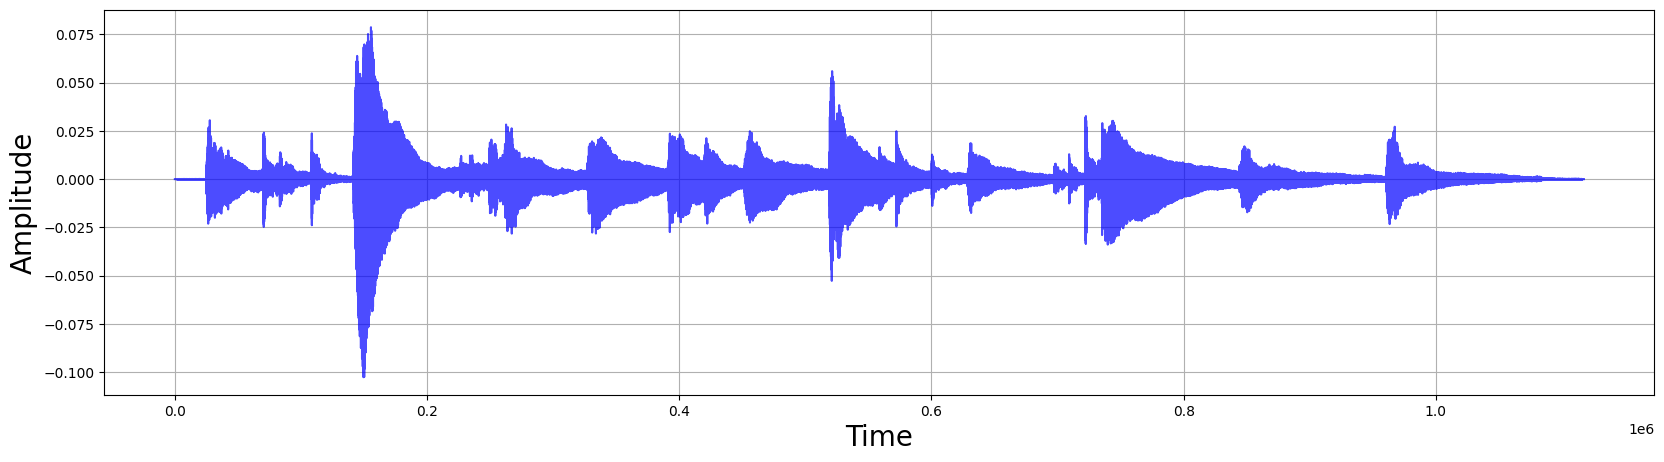

In [ ]:
visualise_audio(waw, sr = dataset.SR)

### Mel 값으로 변환하기

In [ ]:
from pathlib import Path
import torchaudio

def load_data():
    file_list = []
    sample_list = []
    for file in Path('').glob('*_submission/*_submission/*.wav'):
        sample_name = file.stem + '.wav' #re.match(r"(\d+)", file.stem).group(0)
        file_list.append(file)
        sample_list.append(str(sample_name))
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['FileName'] = sample_list
    return dd

In [ ]:
dd = load_data()
dd = dd.set_index('FileName').join(df.set_index('FileName'), how='inner')
dd = dd[dd['Class'].isin(labels)]
dd['label'] = dd['Class'].apply(lambda x: label2id[x])
selected_cols = ['file', 'label', 'Class']
dd = dd[selected_cols]
dd.sample(5).T

FileName,RealDrum01_03HHtrain.wav,FS_G_V_bending.wav,metal_3_135BPM.wav,ROOM_room6_MUS_joplin_DEV_amazon.wav,WaveDrum02_43HH (47).wav
file,Train_submission/Train_submission/RealDrum01_0...,Train_submission/Train_submission/FS_G_V_bendi...,Train_submission/Train_submission/metal_3_135B...,Train_submission/Train_submission/ROOM_room6_M...,Train_submission/Train_submission/WaveDrum02_4...
label,1,0,0,2,3
Class,Sound_Drum,Sound_Guitar,Sound_Guitar,Sound_Piano,Sound_Violin


In [ ]:
dd = dd.reset_index(drop=True)
dd.head()

,file,label,Class
0,Train_submission/Train_submission/029500_morni...,2,Sound_Piano
1,Train_submission/Train_submission/035568_uprig...,2,Sound_Piano
2,Train_submission/Train_submission/04-47367.wav,1,Sound_Drum
3,Train_submission/Train_submission/04-47367.wav,3,Sound_Violin
4,Train_submission/Train_submission/046578_triba...,1,Sound_Drum


In [ ]:
def Feature_extractor(file_path):
    # 음악 파일 로드, 해당 파일의 오디오 데이터와 샘플링 속도 반환
    audio, sample_rate = librosa.load(str(file_path), res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    # 정규화된 MFCC 특징 반환
    return mfccs_scaled_features,sample_rate

In [ ]:
extracted_features=[]
extracted_rate = []
for index,row in tqdm(dd.iterrows()):
    file_path = row['file']
    final_class_label = row['Class']  # Assuming 'Class' is the column containing class labels
    data, sr=Feature_extractor(file_path)
    extracted_features.append([data])
    extracted_rate.append(sr)

2629it [13:12,  3.32it/s]


In [ ]:
dd['feature']=extracted_features

In [ ]:
extracted_rate

In [ ]:
dd

,file,label,Class,feature
0,Train_submission/Train_submission/029500_morni...,2,Sound_Piano,"[[-391.31836, 167.01129, 11.016864, 2.181573, ..."
1,Train_submission/Train_submission/035568_uprig...,2,Sound_Piano,"[[-649.3114, 102.29075, 52.36694, 19.935278, 8..."
2,Train_submission/Train_submission/04-47367.wav,1,Sound_Drum,"[[-122.803505, 66.70081, -15.50937, 25.863022,..."
3,Train_submission/Train_submission/04-47367.wav,3,Sound_Violin,"[[-122.803505, 66.70081, -15.50937, 25.863022,..."
4,Train_submission/Train_submission/046578_triba...,1,Sound_Drum,"[[-124.61078, 46.562347, 53.75595, 67.478966, ..."
...,...,...,...,...
2624,Train_submission/Train_submission/strange-pian...,2,Sound_Piano,"[[-340.2557, 139.22214, -60.47418, 31.721258, ..."
2625,Train_submission/Train_submission/the-last-pia...,2,Sound_Piano,"[[-369.50864, 226.44633, -21.799685, -10.73569..."
2626,Train_submission/Train_submission/this-is-war-...,2,Sound_Piano,"[[-355.62, 168.70683, 15.937247, 8.451197, 13...."
2627,Train_submission/Train_submission/tired-ghosts...,2,Sound_Piano,"[[-624.9958, 124.9852, 62.212925, 22.685425, 1..."


In [ ]:
# from sklearn.preprocessing import LabelEncoder
X=np.array(dd['feature'].tolist())
y=np.array(dd["label"].tolist())

In [ ]:
X.shape

(2629, 1, 40)

In [ ]:
y

array([2, 2, 1, ..., 2, 2, 2])

In [ ]:
print(dd['feature'][0])

[array([-3.91318359e+02,  1.67011292e+02,  1.10168638e+01,  2.18157291e+00,
        9.18151760e+00, -2.75399280e+00,  5.12870312e-01,  1.06217706e+00,
       -4.89515162e+00, -7.69560194e+00, -1.03921299e+01, -7.56495667e+00,
        1.54135942e+00,  6.21416521e+00,  2.47368956e+00, -1.23543131e+00,
        1.15466738e+00, -4.85515177e-01,  5.45977533e-01,  8.08689880e+00,
        5.67252970e+00, -2.92514157e+00, -2.26791358e+00,  1.70364845e+00,
        1.18935561e+00, -1.01181686e+00, -2.95740604e+00,  4.92143965e+00,
        6.76138973e+00, -9.50563049e+00, -1.36096325e+01, -1.33412504e+00,
        2.62620258e+00, -2.04868960e+00,  3.42931449e-01,  3.60147166e+00,
        1.80371070e+00,  3.33607078e+00,  4.95880365e+00,  3.55356455e+00],
      dtype=float32)]


#### Mel Frequency 시각화

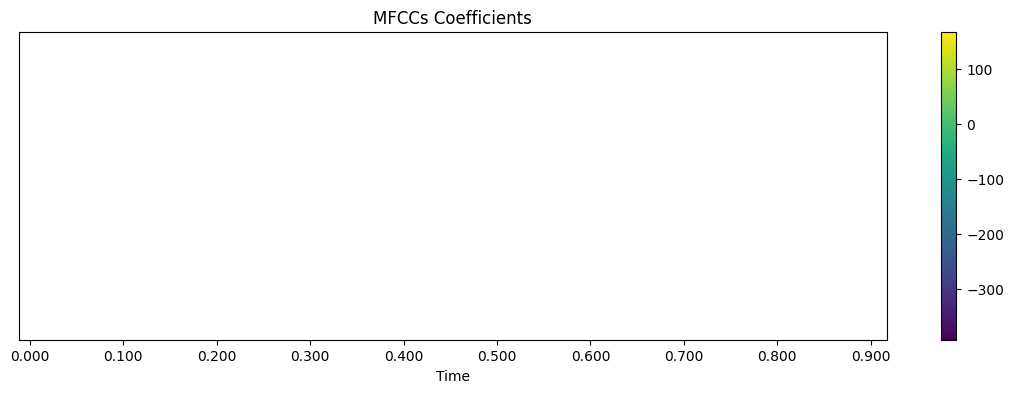

In [ ]:
plt.figure(figsize=(14, 4))
# dd['feature'][0]을 numpy 배열로 변환
mfcc_data = np.array(dd['feature'][0], dtype=np.float32)

# extracted_rate[0] 값을 실수로 변환
sr = float(extracted_rate[0])

librosa.display.specshow(mfcc_data, sr=sr, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title('MFCCs Coefficients')
plt.show()

#데이터셋 분할

In [ ]:
from tensorflow.keras.utils import to_categorical #one-hot-coding
from sklearn.preprocessing import LabelEncoder

LE=LabelEncoder()
y=to_categorical(LE.fit_transform(y)) #원핫코딩 변환 (다중클래스 분류)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [ ]:
print("Shape Of X_train:",X_train.shape)
print("Shape Of X_test:",X_test.shape)
print("Shape Of y_train:",y_train.shape)
print("Shape Of y_test:",y_test.shape)

Shape Of X_train: (2103, 1, 40)
Shape Of X_test: (526, 1, 40)
Shape Of y_train: (2103, 4)
Shape Of y_test: (526, 4)


In [ ]:
# X_train의 두 번째 차원 제거 (각 샘플의 프레임들을 평탄화)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [ ]:
num_labels = y.shape[1]

In [ ]:
num_labels

4

In [ ]:
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

#모델 정의

In [ ]:
# Creating Our Model
#CNN

model=Sequential()
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels))
model.add(Activation('softmax'))



In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               4100      
                                                                 
 activation_15 (Activation)  (None, 100)               0         
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 200)               20200     
                                                                 
 activation_16 (Activation)  (None, 200)               0         
                                                                 
 dropout_13 (Dropout)        (None, 200)               0         
                                                                 
 dense_17 (Dense)            (None, 200)              

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

#훈련시키기

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# tf.keras.callbacks.ModelCheckpoint
from datetime import datetime
import keras
from keras.models import Sequential
from keras.layers import Dense

num_epochs=100
num_batch_size=32


checkpointer=ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',verbose=1,save_best_only=True)
start=datetime.now()
history = model.fit(X_train_reshaped, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test_reshaped, y_test), callbacks=checkpointer)
duration=datetime.now()-start
print("Training Completed in time: ",duration)

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 12.9559 - accuracy: 0.3015
Epoch 1: val_loss improved from inf to 1.31016, saving model to saved_models/audio_classification.hdf5
66/66 [==============================] - 2s 9ms/step - loss: 12.9559 - accuracy: 0.3015 - val_loss: 1.3102 - val_accuracy: 0.2928
Epoch 2/100
58/66 [=========================>....] - ETA: 0s - loss: 3.4340 - accuracy: 0.3411
Epoch 2: val_loss improved from 1.31016 to 1.11668, saving model to saved_models/audio_classification.hdf5
66/66 [==============================] - 0s 5ms/step - loss: 3.3295 - accuracy: 0.3419 - val_loss: 1.1167 - val_accuracy: 0.5437
Epoch 3/100
56/66 [========================>.....] - ETA: 0s - loss: 2.0437 - accuracy: 0.3677
Epoch 3: val_loss did not improve from 1.11668
66/66 [==============================] - 0s 5ms/step - loss: 1.9921 - accuracy: 0.3738 - val_loss: 1.1254 - val_accuracy: 0.4525
Epoch 4/100
61/66 [==========================>...] - ETA: 0s - loss: 

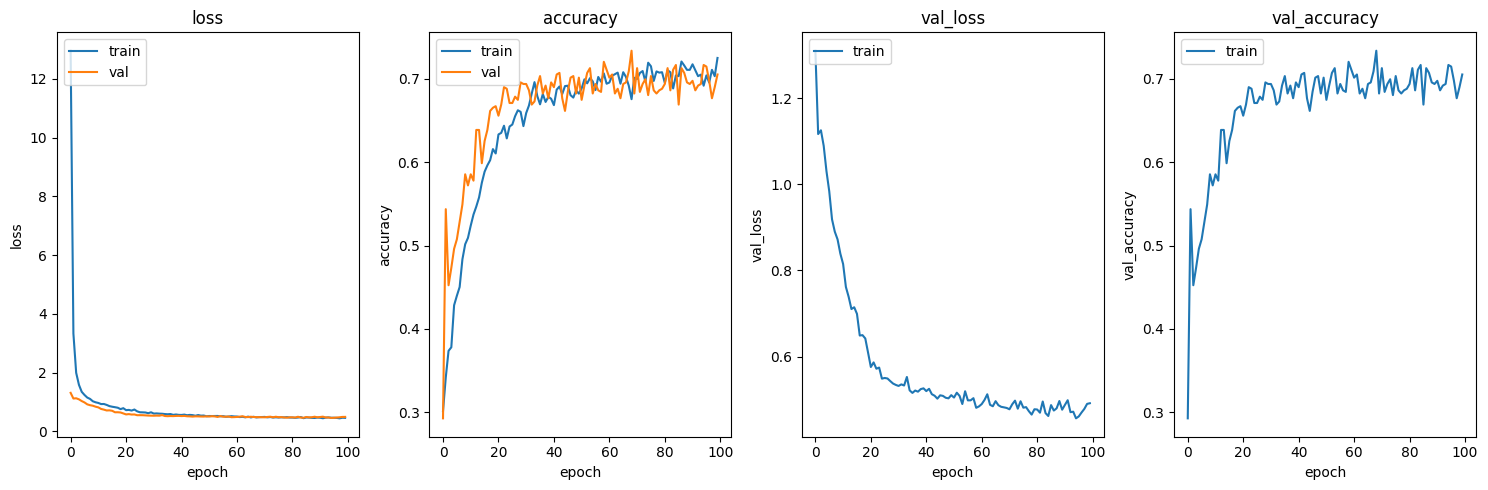

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    key_value = history.history.keys()
    plt.figure(figsize=(15,5))
    for idx , key in enumerate(key_value):
        plt.subplot(1, len(key_value), idx+1)
        plt.plot(history.history[key], label='Training')

        # Check if validation data is available
        val_key = 'val_' + key
        if val_key in history.history:
            plt.plot(history.history[val_key], label='Validation')
        plt.title(key)
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
    plt.tight_layout()
    plt.show()

# Assuming you have already trained your model and obtained the 'history' object
plot_history(history)

In [ ]:
test_accuracy=model.evaluate(X_test_reshaped,y_test,verbose=0)
print(test_accuracy[1])

0.7053232192993164


In [ ]:
model.load_weights('saved_models/audio_classification.hdf5')

17/17 [==============================] - 0s 3ms/step


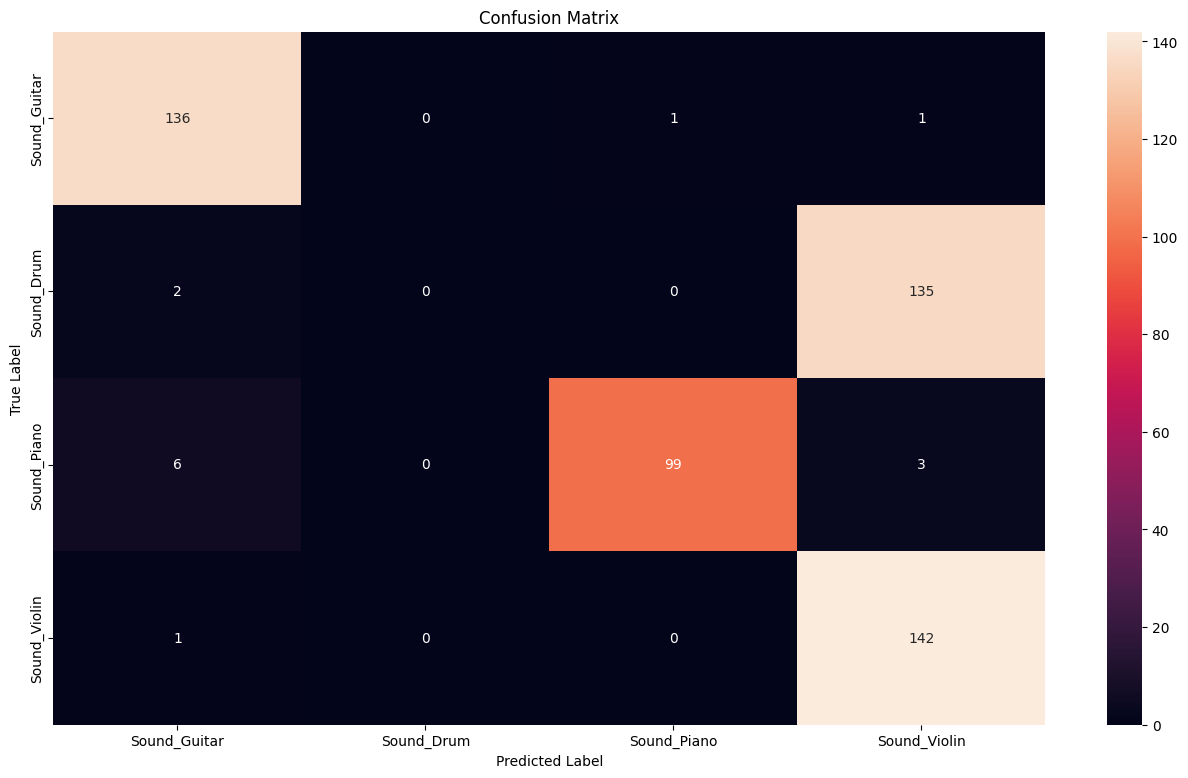

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 예측 수행
y_preds = model.predict(X_test_reshaped)
# 예측값 중 가장 높은 확률을 가진 클래스 선택
y_preds_argmax = np.argmax(y_preds, axis=1)
# 실제 레이블 중 가장 높은 확률을 가진 클래스 선택
y_test_argmax = np.argmax(y_test, axis=1)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_argmax, y_preds_argmax)

# 혼동 행렬 시각화
plt.figure(figsize=(16, 9))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    xticklabels=["Sound_Guitar", "Sound_Drum", "Sound_Piano", "Sound_Violin"],
    yticklabels=["Sound_Guitar", "Sound_Drum", "Sound_Piano", "Sound_Violin"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
#Youtube APUI 를 이용해서 음성 파일 추출
!pip install pytube

In [ ]:
from pytube import YouTube

def download_youtube_audio(youtube_url, start_time, end_time, output_path):
    yt = YouTube(youtube_url)
    video = yt.streams.filter(only_audio=True).first()

    # Download audio with a specific start and end time
    video.download(output_path, filename=f'{start_time}_{end_time}.mp3')

# Example usage
youtube_url = 'https://www.youtube.com/watch?v=CTtUeNabfDk'
start_time = 10  # Example start time in seconds
end_time = 60    # Example end time in seconds
output_path = 'path/to/save/audio'
download_youtube_audio(youtube_url, start_time, end_time, output_path)

In [ ]:
# 오디오 파일을 모델 입력 형식으로 가공
def preprocess_audio(audio_path):
    # Load the audio file
    audio, sr = librosa.load(audio_path, res_type='kaiser_fast')

    # Extract MFCC features
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    # Reshape for model input
    model_input = mfccs_scaled_features.reshape(1, -1)

    return model_input


# 예측 결과 해석
def interpret_prediction(prediction, label2id):
    predicted_label_id = np.argmax(prediction)
    predicted_label = label2id[predicted_label_id]
    return predicted_label


In [ ]:
# 다운로드한 오디오 파일 전처리 및 모델 예측
downloaded_audio_path = f'{output_path}/{start_time}_{end_time}.mp3'
model_input = preprocess_audio(downloaded_audio_path)
prediction = model.predict(model_input)
predicted_label = interpret_prediction(prediction, id2label)

print(f"Predicted Instrument: {predicted_label}")

1/1 [==============================] - 0s 31ms/step
Predicted Instrument: Sound_Guitar


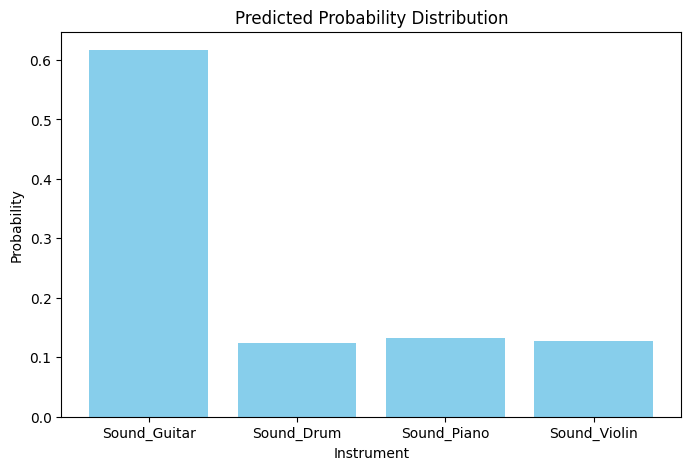

In [ ]:
# 예측 결과를 시각화
plt.figure(figsize=(8, 5))
plt.bar(id2label.values(), prediction.flatten(), color='skyblue')
plt.title("Predicted Probability Distribution")
plt.xlabel("Instrument")
plt.ylabel("Probability")
plt.show()